In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from torchvision.ops.boxes import batched_nms, box_area
import cv2
import numpy as np
import logging
import glob
import os

from src.model.utils import Detections
from cnos_clustering_utils import (move_to_device, tighten_bboxes, extract_object_by_mask, _remove_very_small_detections, 
                                    plot_images, extract_sam_crops_features, hierarchical_clustering, analyze_tsne_with_svm
                                    , analyze_tsne_with_kmeans, analyze_tsne_with_svm_3d, analyze_tsne_with_svm_2, analyze_tsne_with_hdbscan)
from src.model.custom_cnos import cnos_templates_feature_extraction
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
from sklearn.manifold import TSNE

# Create a logger
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] [%(levelname)s] %(name)s: %(message)s')
log = logging.getLogger(__name__)

In [40]:
dataset = "daoliuzhao"
rgb_path = "datasets/bop23_challenge/datasets/daoliuzhao/test/000035/rgb/000042.png" # f"datasets/bop23_challenge/datasets/{dataset}/test/000048/rgb/000001.png"
obj_id = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model) #, crop_overlap_ratio = 750 / 1500) # , box_nms_thresh = 0.6 )
move_to_device(custom_sam_model)

rgb = Image.open(rgb_path).convert("RGB")
sam_detections = custom_sam_model.generate_masks(np.array(rgb))

# Remove noise and filter too small and too big crops
noise_remove_sam_detections = tighten_bboxes(sam_detections)
keep_ids = _remove_very_small_detections(noise_remove_sam_detections["masks"], noise_remove_sam_detections["boxes"]) # torch.arange(len(noise_remove_sam_detections["masks"])) # 
selected_masks = [noise_remove_sam_detections["masks"][i] for i in range(len(keep_ids)) if keep_ids[i]]
selected_bboxes = [noise_remove_sam_detections["boxes"][i] for i in range(len(keep_ids)) if keep_ids[i]]
# noise_remove_sam_detections = sam_detections
# keep_ids = torch.arange(0, len(noise_remove_sam_detections["masks"]))#  _remove_very_small_detections(noise_remove_sam_detections["masks"], noise_remove_sam_detections["boxes"]) # torch.arange(len(noise_remove_sam_detections["masks"])) # 
# selected_masks = [noise_remove_sam_detections["masks"][i] for i in range(len(keep_ids))]
# selected_bboxes = [noise_remove_sam_detections["boxes"][i] for i in range(len(keep_ids))]
selected_sam_detections = {
    "masks" : torch.stack(selected_masks),
    "boxes" : torch.stack(selected_bboxes)
}
log.info(len(selected_sam_detections["masks"]))
log.info(len(sam_detections["masks"]))

masked_images = []
for mask in selected_sam_detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)
    
# # Plot sam crops
# rows = ceil(len(masked_images) / 6)
# cols = 6
# plot_images(masked_images, rows, cols) 

# Load synthetic train_pbr templates 
# out_folder = f"foundpose_analysis/{dataset}/templates"
# obj_id_2 = 2
# syn_data_type = "train_pbr" # test
# syn_template_path_1 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id:06d}_original" 
# syn_template_path_2 = f"{out_folder}/{syn_data_type}_images_templates/obj_{obj_id_2:06d}_original" 
# syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
# syn_template_files_2 = sorted(glob.glob(os.path.join(syn_template_path_2, "*.png")), key=os.path.getmtime)

syn_template_path_1 = f"foundpose_analysis/daoliuzhao/templates/train_pbr/obj_000001_original" 
syn_template_files_1 = sorted(glob.glob(os.path.join(syn_template_path_1, "*.png")), key=os.path.getmtime)
syn_template_files = syn_template_files_1 # + syn_template_files_2
syn_num_templates = len(syn_template_files)
syn_templates = [np.array(Image.open(template_file).convert("RGB"))[:,:,:3] for template_file in syn_template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

# Load Dinov2
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)

# Extract features of templates
syn_ref_features = cnos_templates_feature_extraction(
    templates = syn_templates, num_templates = syn_num_templates, dino_model = dinov2_vitl14, device = device
    )

# Extract feature for all crops
crop_features = extract_sam_crops_features(masked_images, dinov2_vitl14, device)

[2024-12-31 22:55:07,504] [INFO] root: Loading SAM model from datasets/bop23_challenge/pretrained/segment-anything
[2024-12-31 22:55:11,133] [INFO] root: Init CustomSamAutomaticMaskGenerator done!
[2024-12-31 22:55:13,899] [INFO] __main__: 66
[2024-12-31 22:55:13,900] [INFO] __main__: 118
Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main
[2024-12-31 22:55:14,724] [INFO] dinov2: using MLP layer as FFN
/home/cuong.van-dam/CuongVanDam/do_an_tot_nghiep/cnos/src/model/constrastive_learning_utils.py:383: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_image = F.interpolate(torch.tensor(image).unsqueeze(0), scale_factor=scale_factor.item())[0] # unsqueeze at  0 - B,C, H, W


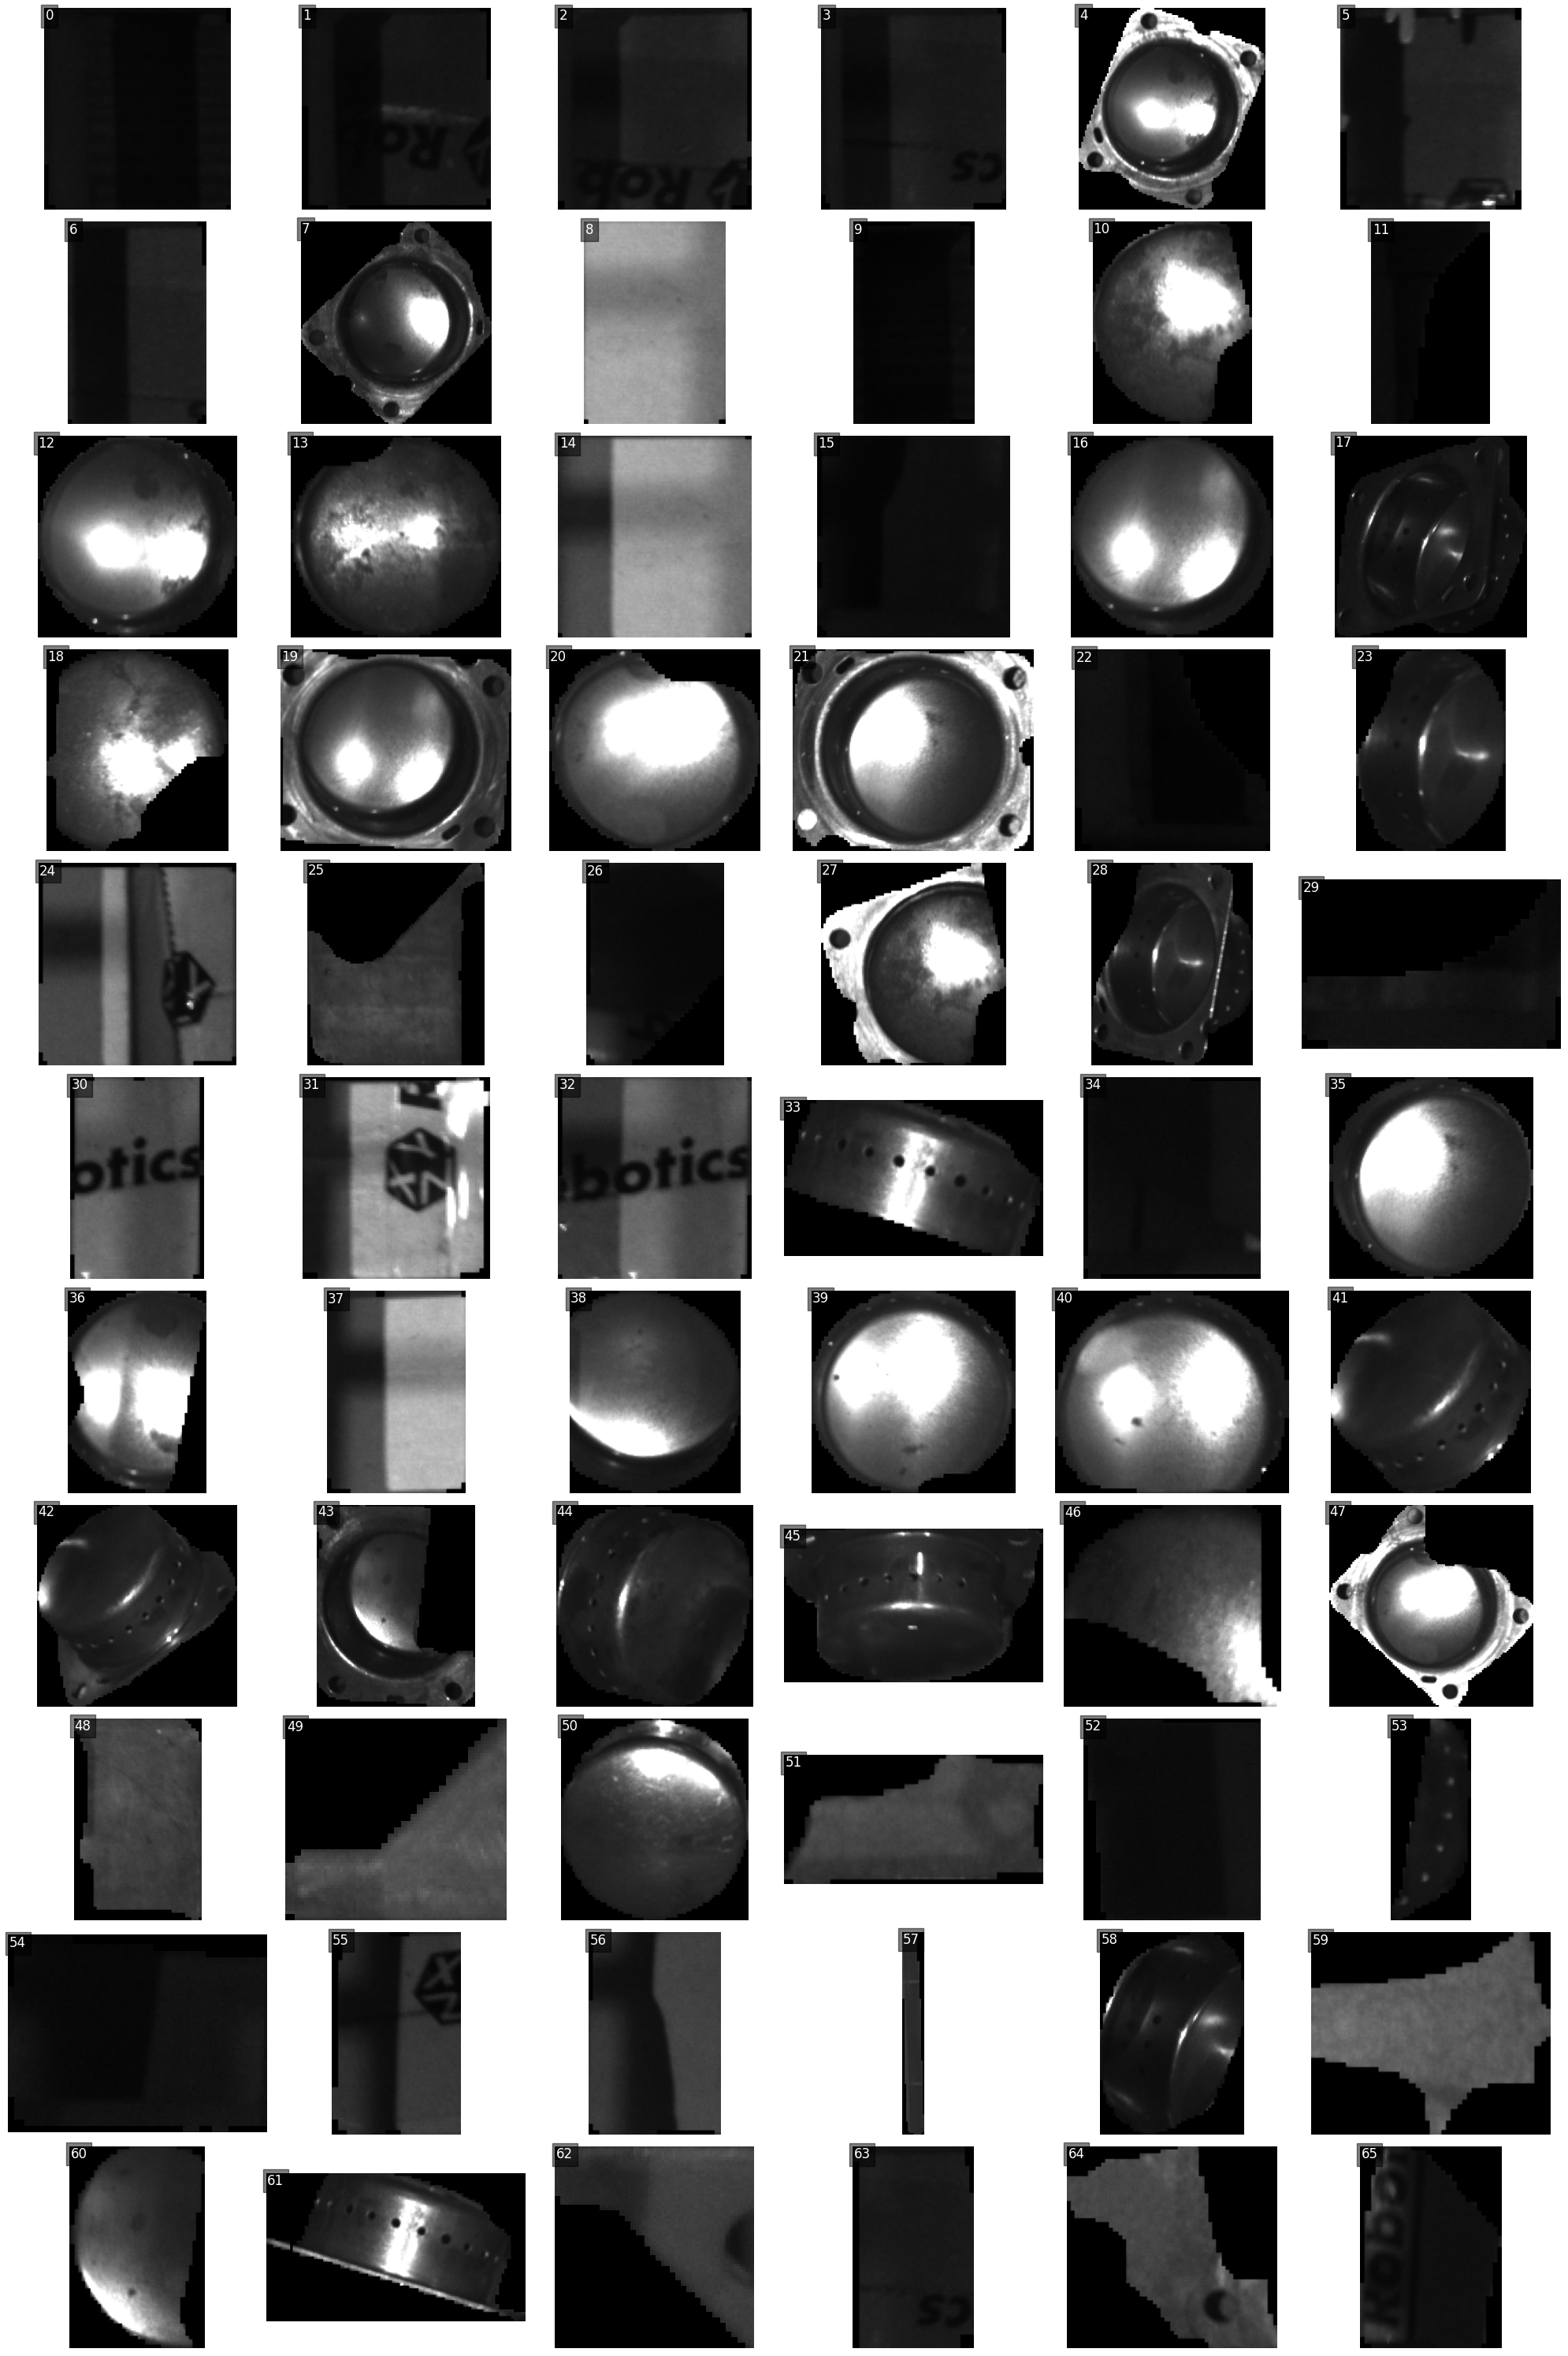

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt
from math import ceil

def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
        # Add index at the top left corner of each subplot
        ax.text(0, 0, f'{i}', color='white', fontsize=12, ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5))
    plt.tight_layout()
    plt.show()
    plt.savefig('output_plot.png', bbox_inches='tight', dpi=300)


# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6

# Plot the masked_images array in a grid with indices
plot_images(masked_images, rows, cols)

In [43]:
# rgb

In [44]:
input_features = torch.cat((crop_features, syn_ref_features), dim=0) # (num_samples, 1024)

In [45]:
log.info(input_features.shape)

# Create and fit the t-SNE model
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(np.array(input_features.cpu()))    
tsne_results_2 = tsne.fit_transform(np.array(crop_features.cpu()))    

log.info("Done")

[2024-12-31 22:55:22,292] [INFO] __main__: torch.Size([228, 1024])
[2024-12-31 22:55:22,934] [INFO] __main__: Done


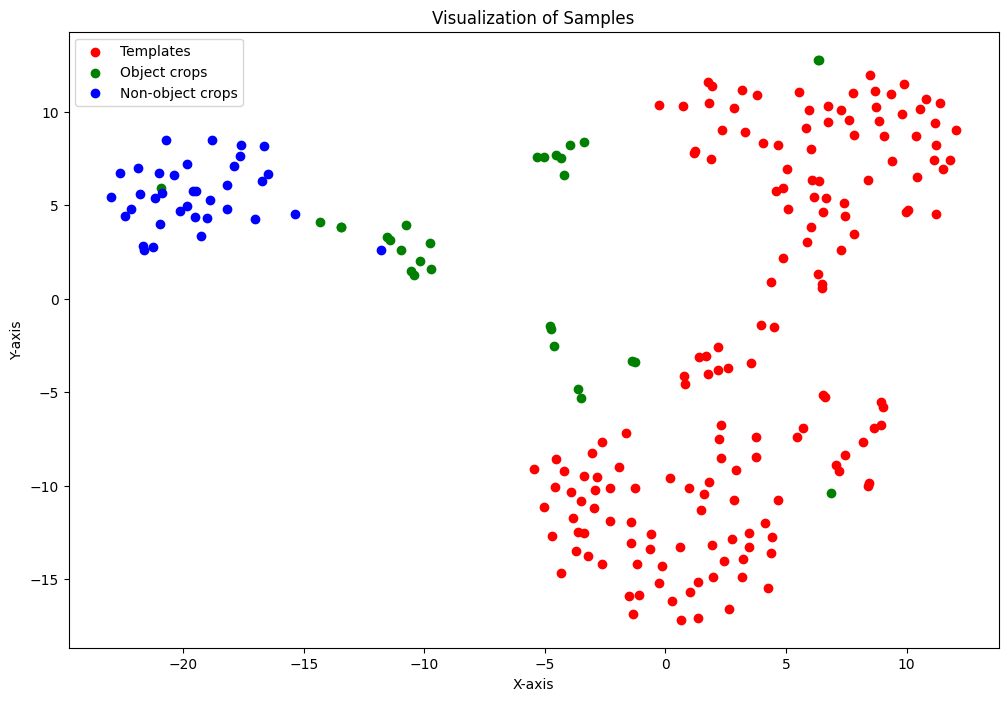

[0, 1, 2, 5, 6, 8, 9, 11, 13, 14, 15, 22, 24, 25, 26, 29, 30, 31, 32, 34, 37, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 59, 62, 63, 64, 65]


In [66]:
def plot_samples(samples, total_points=113, first_group_size=162):
    # Create a larger figure
    plt.figure(figsize=(12, 8))  # Width = 12, Height = 8


    
    # Separate the first group and the second group based on the parameter values
    first_group = samples[-first_group_size:]
    
    # second_group = samples[first_group_size:total_points] 
    positive_indices =  [4, 7, 10, 12, 3, 16, 17, 18, 19, 20, 21, 23, 
           27, 28, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 
           45, 47, 50, 58, 60, 61]
    # [4, 9, 12, 16, 19, 21, 22, 23, 25, 26, 28, 30, 
    #        33, 35, 38, 39, 40, 41, 43, 44, 45, 46, 48, 50, 
    #        51, 54, 57, 58, 59, 60, 61, 62, 63, 67, 68, 70] # posotive crops
    second_group = samples[positive_indices]

    negative_indices = [i for i in range(len(samples)-first_group_size) if i not in positive_indices]
    third_group = samples[negative_indices]
    
    # Create a scatter plot for the first group (red points)
    plt.scatter([p[0] for p in first_group], [p[1] for p in first_group], color='red', label="Templates") # f'First {first_group_size} points')
    
    # Create a scatter plot for the second group (green points) and add indices
    plt.scatter([p[0] for p in second_group], [p[1] for p in second_group], color='green', label= "Object crops" )#f'Last {total_points - first_group_size} points')

    # Create a scatter plot for the second group (green points) and add indices
    plt.scatter([p[0] for p in third_group], [p[1] for p in third_group], color='blue', label="Non-object crops")
    
    # # Add index labels to the second group points
    # for i, point in enumerate(second_group):
    #     plt.text(point[0], point[1], str(i), fontsize=12, color='black', ha='right')

    # Adding plot labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Visualization of Samples')
    plt.legend()
    plt.show()

    print(negative_indices)

plot_samples(samples=tsne_results, total_points=input_features.shape[0], first_group_size=syn_ref_features.shape[0])

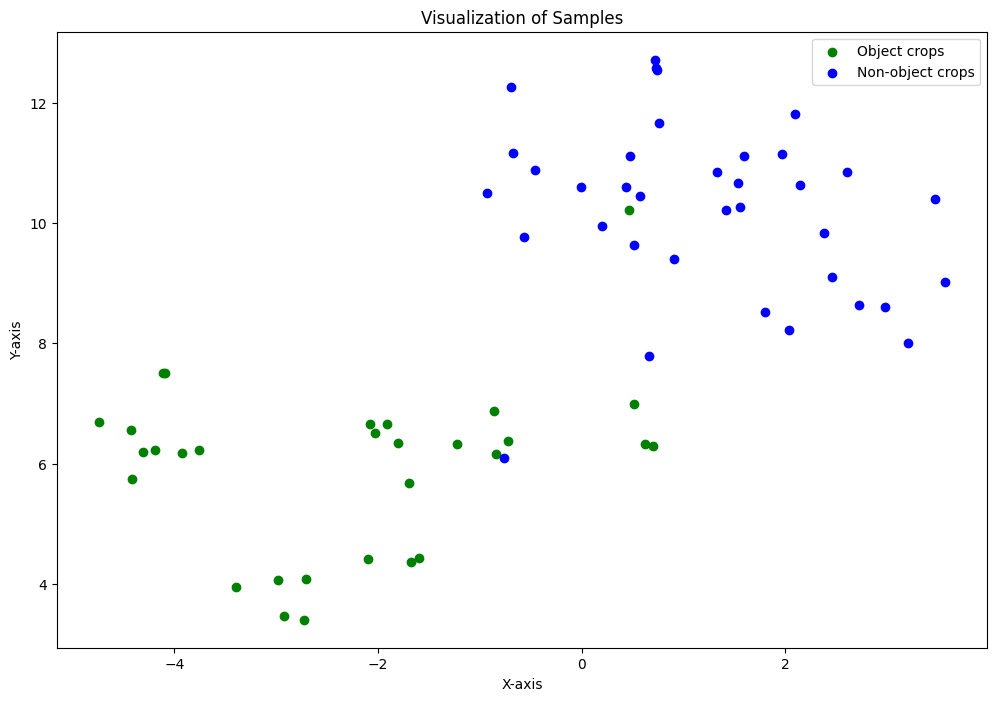

[0, 1, 2, 5, 6, 8, 9, 11, 13, 14, 15, 22, 24, 25, 26, 29, 30, 31, 32, 34, 37, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 59, 62, 63, 64, 65]


In [49]:
def plot_samples_2(samples, total_points=113, first_group_size=162):
    # Create a larger figure
    plt.figure(figsize=(12, 8))  # Width = 12, Height = 8


    
    # Separate the first group and the second group based on the parameter values
    # first_group = samples[-first_group_size:]
    
    # second_group = samples[first_group_size:total_points] 
    positive_indices =  [4, 7, 10, 12, 3, 16, 17, 18, 19, 20, 21, 23, 
           27, 28, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 
           45, 47, 50, 58, 60, 61] # posotive crops
    second_group = samples[positive_indices]

    negative_indices = [i for i in range(len(samples)) if i not in positive_indices]
    third_group = samples[negative_indices]
    
    # Create a scatter plot for the first group (red points)
    # plt.scatter([p[0] for p in first_group], [p[1] for p in first_group], color='red', label="Templates") # f'First {first_group_size} points')
    
    # Create a scatter plot for the second group (green points) and add indices
    plt.scatter([p[0] for p in second_group], [p[1] for p in second_group], color='green', label= "Object crops" )#f'Last {total_points - first_group_size} points')

    # Create a scatter plot for the second group (green points) and add indices
    plt.scatter([p[0] for p in third_group], [p[1] for p in third_group], color='blue', label="Non-object crops")
    
    # # Add index labels to the second group points
    # for i, point in enumerate(second_group):
    #     plt.text(point[0], point[1], str(i), fontsize=12, color='black', ha='right')

    # Adding plot labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Visualization of Samples')
    plt.legend()
    plt.show()

    print(negative_indices)

plot_samples_2(samples=tsne_results_2, total_points=crop_features.shape[0], first_group_size=syn_ref_features.shape[0])

In [54]:
tsne_results_2.shape

(66, 2)

In [59]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def mean_shift_clustering_2clusters(X, initial_bandwidth=1.0, max_iterations=100, tolerance=1e-4):
    """
    Implement Mean Shift clustering algorithm that ensures exactly 2 clusters.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, 2)
        Input data points
    initial_bandwidth : float
        Initial kernel bandwidth parameter
    max_iterations : int
        Maximum number of iterations
    tolerance : float
        Convergence threshold
        
    Returns:
    --------
    labels : array, shape (n_samples,)
        Cluster labels for each point (0 or 1)
    centers : array, shape (2, 2)
        Final 2 cluster centers
    """
    
    def find_centers(bandwidth):
        # Initialize centers as all data points
        centers = X.copy()
        n_points = X.shape[0]
        
        # Mean shift iterations
        for _ in range(max_iterations):
            old_centers = centers.copy()
            distances = cdist(X, centers)
            weights = np.exp(-distances**2 / (2 * bandwidth**2))
            
            for i in range(n_points):
                centers[i] = np.average(X, weights=weights[:, i], axis=0)
            
            if np.max(np.sqrt(np.sum((centers - old_centers)**2, axis=1))) < tolerance:
                break
        
        # Merge close centers
        unique_centers = []
        for center in centers:
            is_unique = True
            for unique_center in unique_centers:
                if np.sqrt(np.sum((center - unique_center)**2)) < bandwidth/2:
                    is_unique = False
                    break
            if is_unique:
                unique_centers.append(center)
        
        return np.array(unique_centers)
    
    # Binary search for bandwidth that gives exactly 2 clusters
    bandwidth = initial_bandwidth
    max_bandwidth = np.max(cdist(X, X))
    min_bandwidth = 0.01
    
    while min_bandwidth < max_bandwidth:
        bandwidth = (min_bandwidth + max_bandwidth) / 2
        centers = find_centers(bandwidth)
        
        if len(centers) == 2:
            break
        elif len(centers) < 2:
            max_bandwidth = bandwidth
        else:
            min_bandwidth = bandwidth
            
    # If we still don't have exactly 2 centers, force it by taking the 2 most distant points
    if len(centers) != 2:
        distances = cdist(centers, centers)
        i, j = np.unravel_index(np.argmax(distances), distances.shape)
        centers = np.array([centers[i], centers[j]])
    
    # Assign points to nearest center
    distances = cdist(X, centers)
    labels = np.argmin(distances, axis=1)
    
    return labels, centers

def visualize_clusters(X, labels, centers):
    """
    Visualize clustering results.
    """
    plt.figure(figsize=(10, 8))
    
    # Plot points
    colors = ['b', 'r']
    for i in range(2):
        cluster_points = X[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   c=colors[i], 
                   label=f'Cluster {i}',
                   alpha=0.6)
    
    # Plot centers
    plt.scatter(centers[:, 0], centers[:, 1], 
               c='black', marker='x', s=200, linewidth=3,
               label='Centroids')
    
    plt.title('Mean Shift Clustering Results (2 Clusters)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()

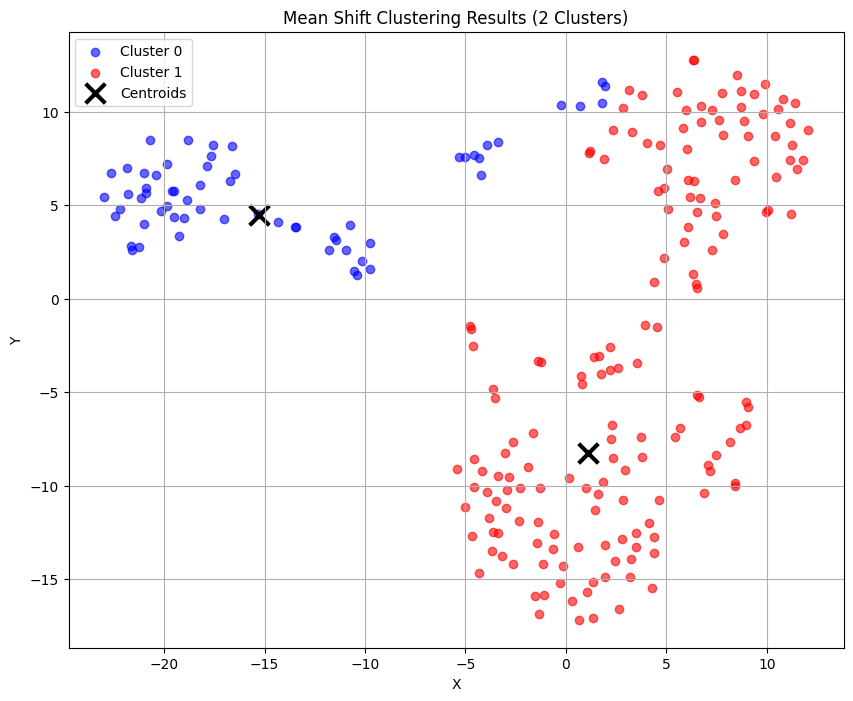

In [63]:
labels, centers = mean_shift_clustering_2clusters(tsne_results, initial_bandwidth=1.0)
visualize_clusters(tsne_results, labels, centers)


Indices of other points in the same cluster as the first class:
[]
Points in the first class: 162
Additional points in the same cluster: 0
Total points in the same cluster: 162
Points in other clusters or noise: 66
Number of noise points: 20


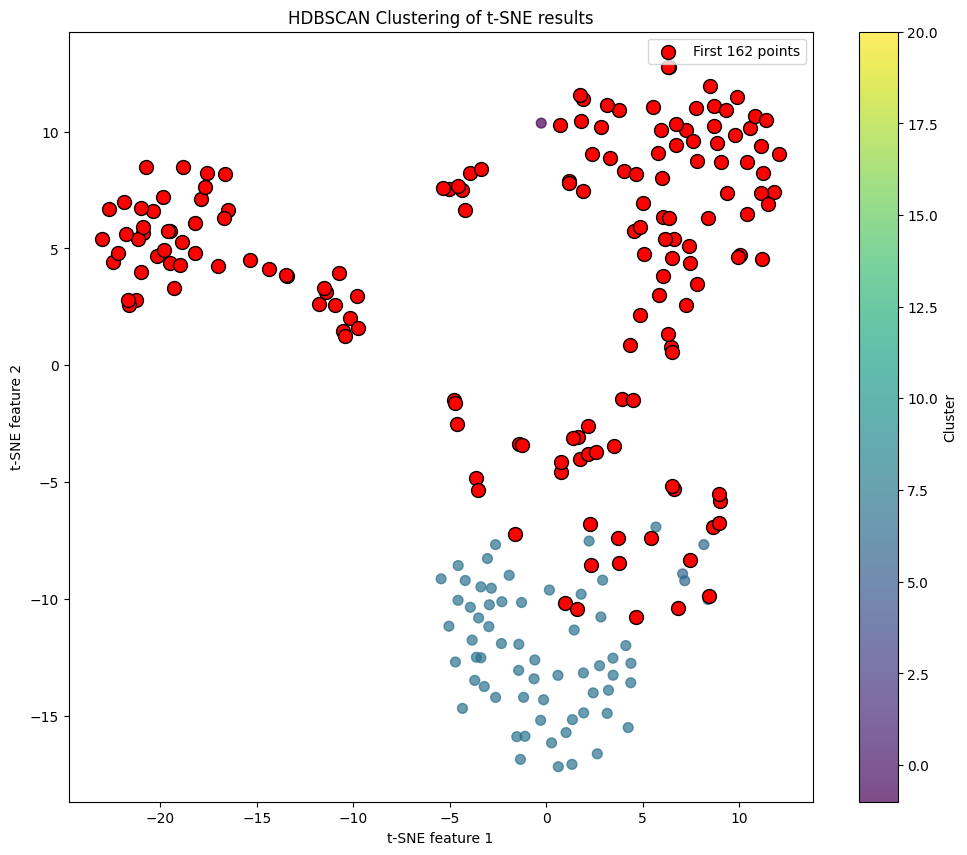

Silhouette Score: 0.39


In [50]:
other_same_class, accuracy = analyze_tsne_with_hdbscan(tsne_results=tsne_results, n_samples_first_class=162, total_samples=input_features.shape[0])

In [ ]:
other_same_class

[]